**加载依赖库**

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests


import torch
from torch import nn
import torch_directml
from torchvision import datasets
from torchvision import transforms


device = torch_directml.device()

**数据预处理**

In [64]:
mean = [0.485, 0.456, 0.406]

std = [0.229, 0.224, 0.225]

image_size = (32, 32)

transform_train = transforms.Compose([
    transforms.Resize(image_size),
    # transforms.RandomRotation(20),
    # transforms.RandomHorizontalFlip(0.1),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    # transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [65]:
batch_size = 64

trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


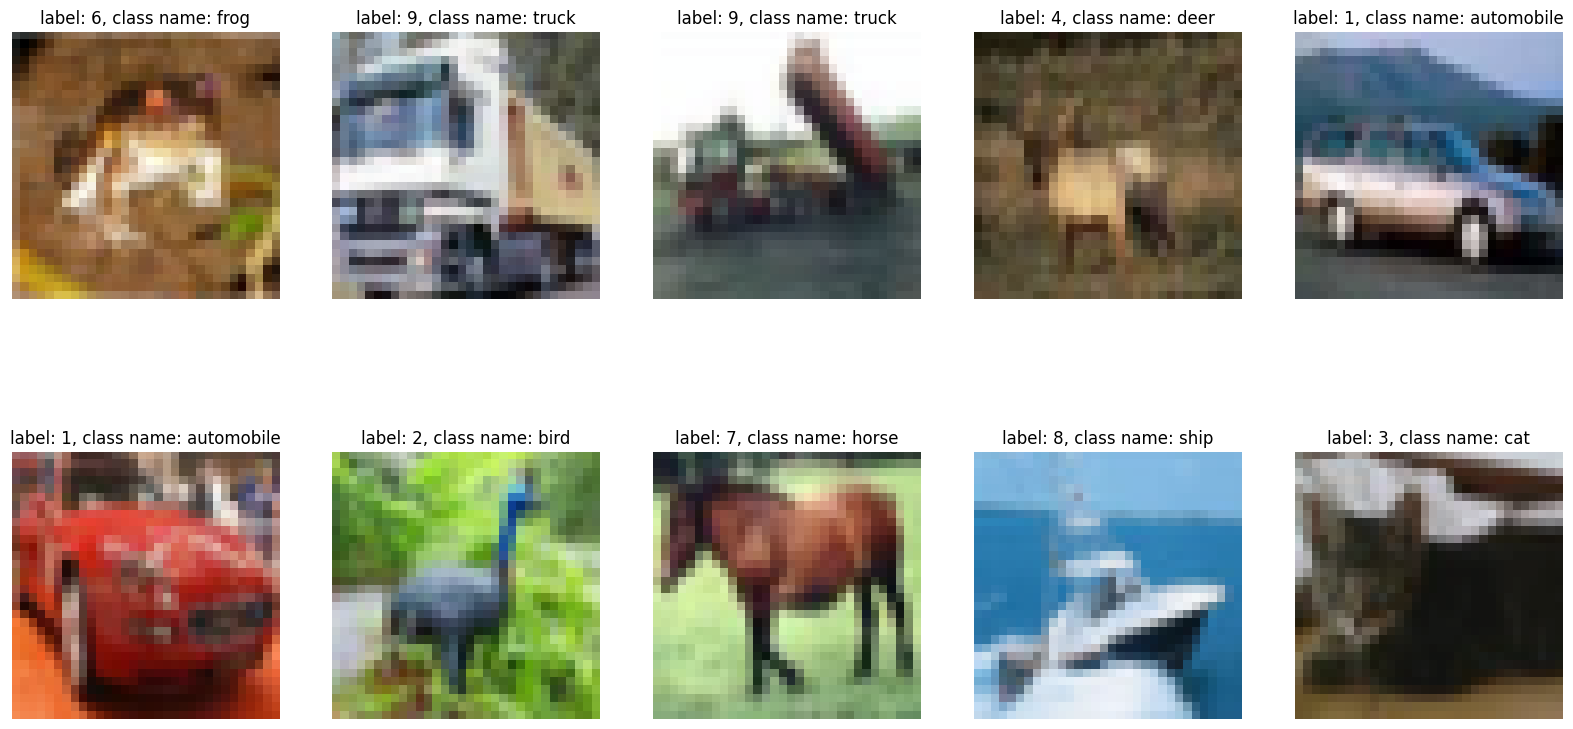

In [86]:
def im_convert(tensor, mean, std):
        image = tensor.cpu().clone().detach().numpy()
        image = image.transpose(1, 2, 0)
        image = image * np.array(tuple(std)) + np.array(tuple(mean))
        return image.clip(0, 1)


def matplotlib_imshow_dataloader(dataloader, mean, std):
    class_names = dataloader.dataset.classes
    data_iterable = iter(dataloader)
    images, labels = next(data_iterable)
    fig = plt.figure(figsize=(20, 10))

    for i in range(10):
        label = labels[i]
        class_name = class_names[label]
        ax = fig.add_subplot(2, 5, i + 1)
        ax.set_title(f"label: {label}, class name: {class_name}")
        ax.axis("off")
        plt.imshow(im_convert(images[i], mean, std))
        
matplotlib_imshow_dataloader(trainloader, mean, std)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        # 将图像数据、标签数据移动到设备
        x, y = x.to(device), y.to(device)

        # 前向传播
        z = model(x)
        # 计算损失
        loss = loss_fn(z, y)

        # 反向传播
        loss.backward()
        # 更新优化器参数
        optimizer.step()
        # 清空梯度
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (z.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Accuracy: {(100 * correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    return train_loss, correct


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            z = model(x)
            test_loss += loss_fn(z, y).item()
            correct += (z.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, correct


def train_model(model, trainloader, testloader, loss_fn, optimizer, epochs=20):
    train_loss_list, train_accuracy_list = [], []
    test_loss_list, test_accuracy_list = [], []

    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        train_loss, train_accuracy = train(trainloader, model, loss_fn, optimizer)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss, test_accuracy = test(testloader, model, loss_fn)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)

    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

**定义模型**

In [68]:
number_of_class_names = len(trainset.classes)


class CNN(nn.Module):
    def __init__(self, number_of_class_names=number_of_class_names):
        super(CNN, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            self.maxpool,
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            self.maxpool,
        )
        self.fc1 = nn.Linear(64 * 64, number_of_class_names)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return (x)

**训练模型**

In [70]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train_model(model, trainloader, testloader, loss_fn, optimizer)

Train Accuracy: 48.5%, Avg loss: 1.456338
Test Accuracy: 47.6%, Avg loss: 1.532118
Train Accuracy: 64.1%, Avg loss: 1.040818
Test Accuracy: 53.9%, Avg loss: 1.442164
Train Accuracy: 69.8%, Avg loss: 0.883021
Test Accuracy: 58.6%, Avg loss: 1.304289
Train Accuracy: 73.4%, Avg loss: 0.779132
Test Accuracy: 65.1%, Avg loss: 1.135972
Train Accuracy: 75.9%, Avg loss: 0.701707
Test Accuracy: 62.6%, Avg loss: 1.261322
Train Accuracy: 78.0%, Avg loss: 0.641576
Test Accuracy: 66.5%, Avg loss: 1.152920
Train Accuracy: 79.5%, Avg loss: 0.593702
Test Accuracy: 66.3%, Avg loss: 1.236822
Train Accuracy: 80.9%, Avg loss: 0.557294
Test Accuracy: 65.6%, Avg loss: 1.285114
Train Accuracy: 81.6%, Avg loss: 0.527931
Test Accuracy: 64.3%, Avg loss: 1.453386
Train Accuracy: 82.7%, Avg loss: 0.497328
Test Accuracy: 64.3%, Avg loss: 1.458386
Train Accuracy: 83.0%, Avg loss: 0.490535
Test Accuracy: 64.8%, Avg loss: 1.576480
Train Accuracy: 83.6%, Avg loss: 0.470092
Test Accuracy: 61.9%, Avg loss: 1.967415
Trai

**保存模型**

In [71]:
torch.save(model.state_dict(), "model.pth")

**加载模型**

In [83]:
test_model = CNN().to(device)
test_model.load_state_dict(torch.load("model.pth", map_location=device))

C:\Users\33695\AppData\Local\Temp\ipykernel_21828\170764071.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("model.pth", map_locati

<All keys matched successfully>

**预测**

Prediction by Model: dog


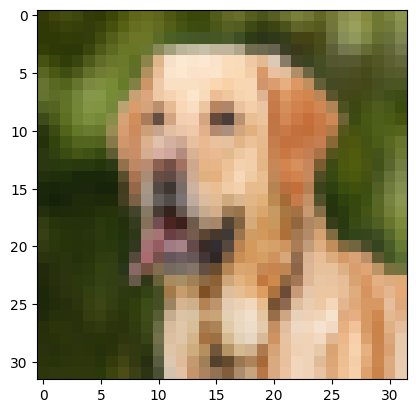

In [90]:
url = 'https://cdn.pixabay.com/photo/2016/02/19/15/46/labrador-retriever-1210559__480.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

# Convert holdout image to testing format
classes_names = trainset.classes
img = transform_test(img)
plt.imshow(im_convert(img, mean, std)) 
image = img.to(device).unsqueeze(0)
output = test_model(image)
_, pred = torch.max(output, 1)
print("Prediction by Model:", (classes_names[pred.item()]))